# Single model

This notebook goes through the solution and simulation of the single model. 

We ensure the correctness of the solution by visualizing consumption and value functions and calculating Euler errors.

We ensure the empirical validity of the model by simulating a lifecycle and calculating retirement probabilities

Finally we time the model and simulation

### Setup

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=8)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import funs
import figs
import transitions

# Global modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Solution

In [2]:
test = RetirementClass()
test.solve()
test.simulate()

### Consumption functions (d=0) for high skilled woman eligible to ERP

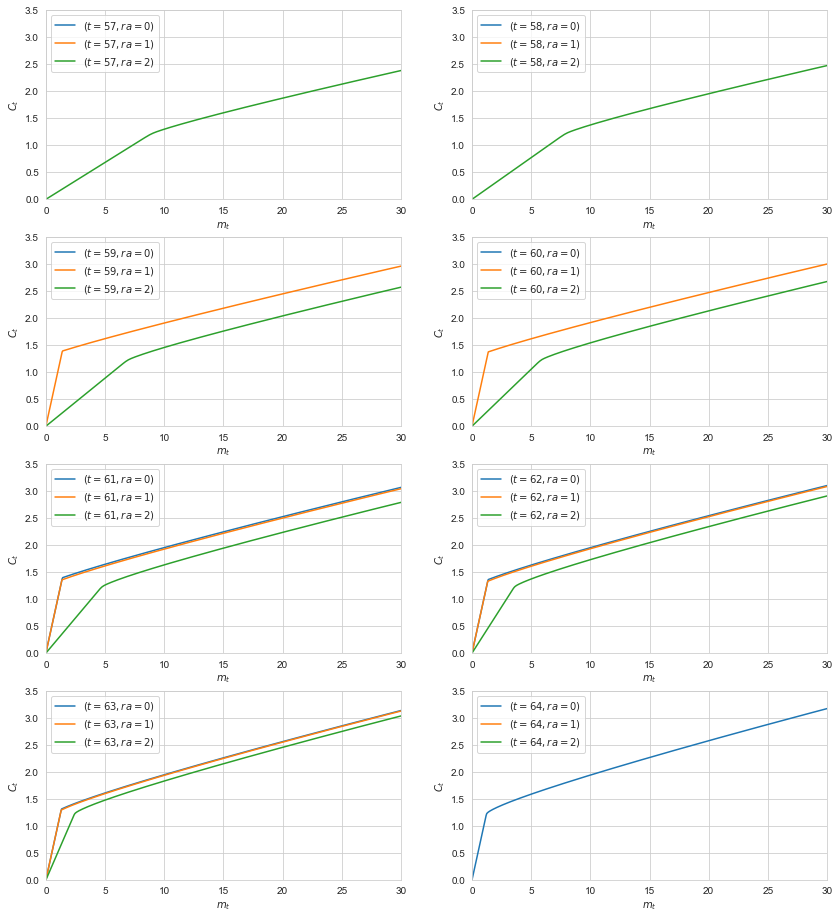

In [3]:
nrow = 4
ncol = 2
fig, axes = plt.subplots(nrow,ncol,figsize=(14,16))
axs = axes.flatten()
for t in range(nrow*ncol):        
    figs.policy(test,axs[t],var='c',T=[t],AD=[0],MA=[0],ST=[3],RA=[0,1,2],D=[0],label=['t','ra'],xlim=[0,30],ylim=[0,3.5])
plt.show()

### Consumption functions (d=1) for high skilled woman eligible to ERP

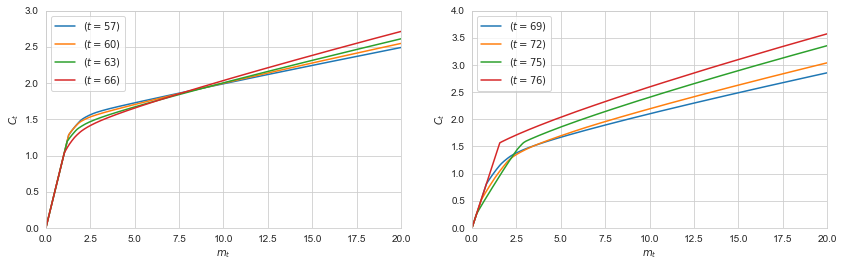

In [4]:
nrow = 1
ncol = 2
fig, axs = plt.subplots(nrow,ncol,figsize=(14,4))
figs.policy(test,axs[0],var='c',T=[0,3,6,9],AD=[0],MA=[0],ST=[3],RA=[0],D=[1],label=['t'],xlim=[0,20],ylim=[0,3])
figs.policy(test,axs[1],var='c',T=[12,15,18,19],AD=[0],MA=[0],ST=[3],RA=[0],D=[1],label=['t'],xlim=[0,20],ylim=[0,4])    
plt.show()

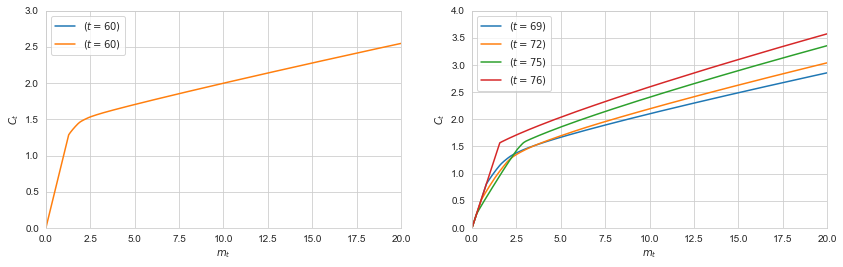

In [5]:
nrow = 1
ncol = 2
fig, axs = plt.subplots(nrow,ncol,figsize=(14,4))
figs.policy(test,axs[0],var='c',T=[3],AD=[0],MA=[0],ST=[3],RA=[0],D=[0,1],label=['t'],xlim=[0,20],ylim=[0,3])
figs.policy(test,axs[1],var='c',T=[12,15,18,19],AD=[0],MA=[0],ST=[3],RA=[0],D=[1],label=['t'],xlim=[0,20],ylim=[0,4])    
plt.show()

### Average retirement probabilities

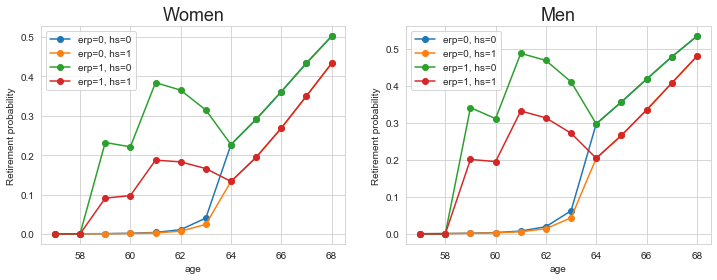

In [7]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.choice_probs(test,axs[0],AD=0,MA=0,ST=[0,1,2,3])
figs.choice_probs(test,axs[1],AD=0,MA=1,ST=[0,1,2,3])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

### Average pension benefit paths

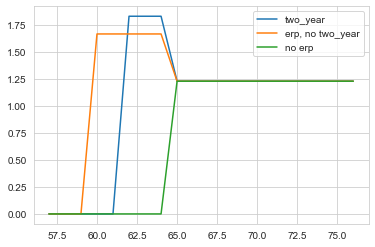

In [8]:
par = test.par
name = ['two_year', 'erp, no two_year', 'no erp']
zoom = 20
for ra in [0,1,2]:
    plt.plot(np.arange(par.start_T,par.start_T+zoom), np.mean(par.pension_arr[:zoom,0,0,ra],axis=1), label=name[ra])
plt.legend()

# Simulate

### Initialized wealth distribution

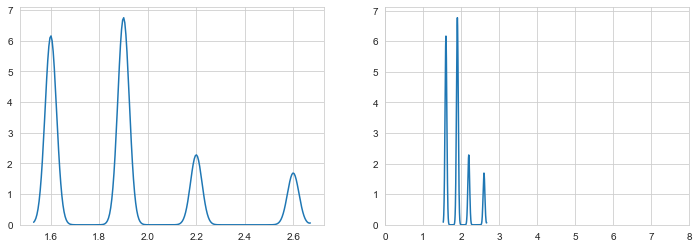

median: 1.9
mean:   1.901
std:    0.307


In [17]:
M_init = test.sim.m[0]
fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.kdeplot(M_init,ax=axs[0],gridsize=200)
axs[1].set_xlim(0,8)
sns.kdeplot(M_init,ax=axs[1],gridsize=500)
plt.show()
print('median:',np.round(np.median(M_init),3))
print('mean:  ',np.round(np.mean(M_init),3))
print('std:   ',np.round(np.std(M_init),3))

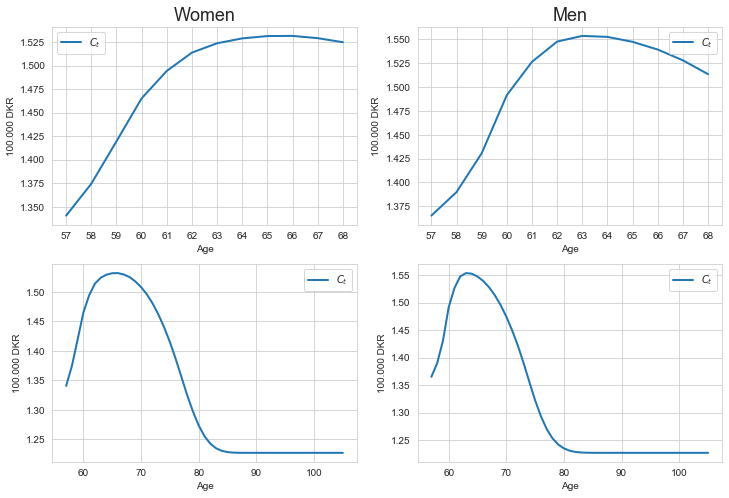

In [9]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(test,axs[0,0],male=0,vars=['c'],quantiles=False)
figs.lifecycle(test,axs[0,1],male=1,vars=['c'],quantiles=False)
figs.lifecycle(test,axs[1,0],male=0,vars=['c'],ages=[57,110],quantiles=False)
figs.lifecycle(test,axs[1,1],male=1,vars=['c'],ages=[57,110],quantiles=False)
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

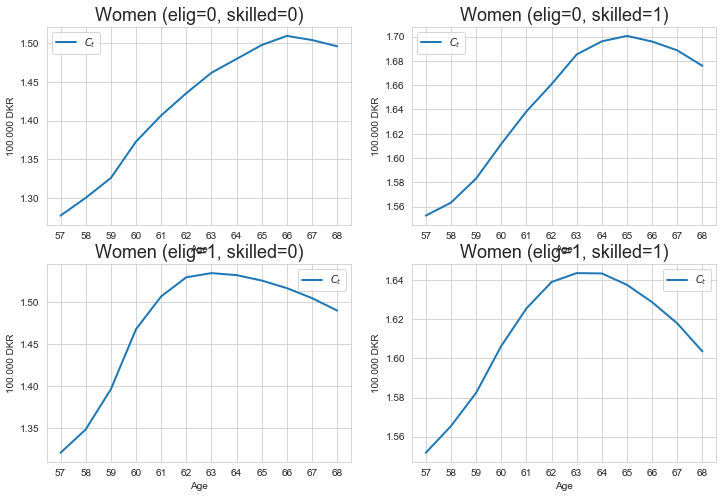

In [10]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(test,axs[0,0],vars=['c'],male=1,states=[0],ages=[57,68],quantiles=False)
figs.lifecycle(test,axs[0,1],vars=['c'],male=1,states=[1],ages=[57,68],quantiles=False)
figs.lifecycle(test,axs[1,0],vars=['c'],male=1,states=[2],ages=[57,68],quantiles=False)
figs.lifecycle(test,axs[1,1],vars=['c'],male=1,states=[3],ages=[57,68],quantiles=False)
axs[0,0].set_title('Women (elig=0, skilled=0)',size=18)
axs[0,1].set_title('Women (elig=0, skilled=1)',size=18)
axs[1,0].set_title('Women (elig=1, skilled=0)',size=18)
axs[1,1].set_title('Women (elig=1, skilled=1)',size=18)
plt.show()

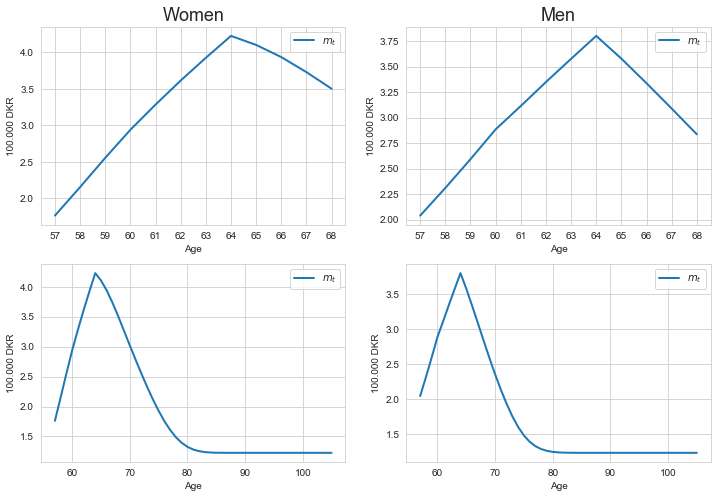

In [11]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(test,axs[0,0],male=0,vars=['m'],quantiles=False)
figs.lifecycle(test,axs[0,1],male=1,vars=['m'],quantiles=False)
figs.lifecycle(test,axs[1,0],male=0,vars=['m'],ages=[57,110],quantiles=False)
figs.lifecycle(test,axs[1,1],male=1,vars=['m'],ages=[57,110],quantiles=False)
axs[0,0].set_title('Women',size=18)
axs[0,1].set_title('Men',size=18)
plt.show()

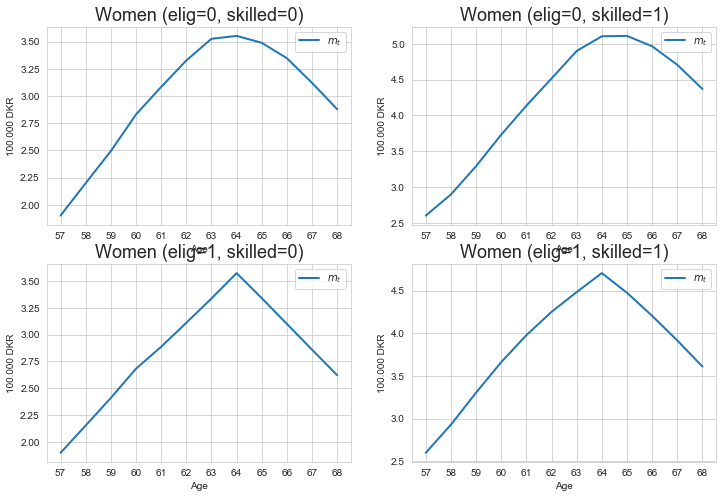

In [12]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.lifecycle(test,axs[0,0],vars=['m'],male=1,states=[0],ages=[57,68],quantiles=False)
figs.lifecycle(test,axs[0,1],vars=['m'],male=1,states=[1],ages=[57,68],quantiles=False)
figs.lifecycle(test,axs[1,0],vars=['m'],male=1,states=[2],ages=[57,68],quantiles=False)
figs.lifecycle(test,axs[1,1],vars=['m'],male=1,states=[3],ages=[57,68],quantiles=False)
axs[0,0].set_title('Women (elig=0, skilled=0)',size=18)
axs[0,1].set_title('Women (elig=0, skilled=1)',size=18)
axs[1,0].set_title('Women (elig=1, skilled=0)',size=18)
axs[1,1].set_title('Women (elig=1, skilled=1)',size=18)
plt.show()

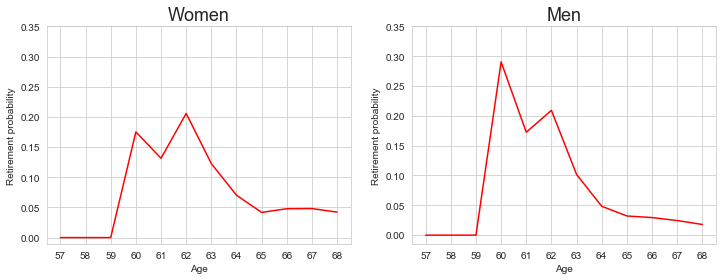

In [15]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
figs.retirement_probs(test,axs[0],male=0,states=[0,1,2,3])
figs.retirement_probs(test,axs[1],male=1,states=[0,1,2,3])
axs[0].set_title('Women',size=18)
axs[1].set_title('Men',size=18)
plt.show()

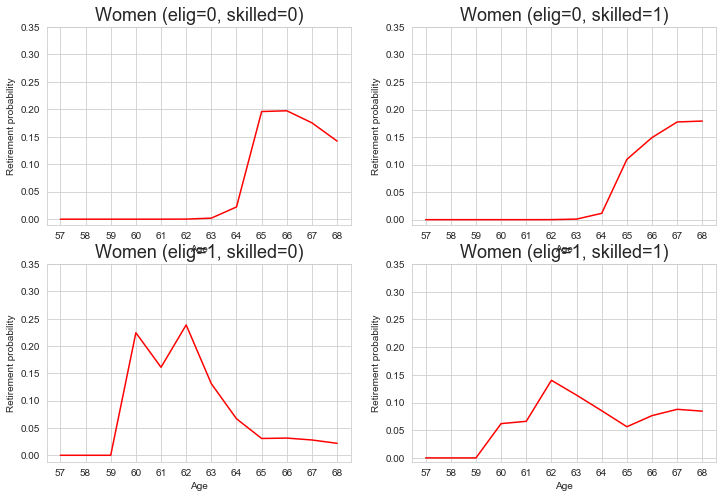

In [13]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
figs.retirement_probs(test,axs[0,0],male=0,states=[0])
figs.retirement_probs(test,axs[0,1],male=0,states=[1])
figs.retirement_probs(test,axs[1,0],male=0,states=[2])
figs.retirement_probs(test,axs[1,1],male=0,states=[3])
axs[0,0].set_title('Women (elig=0, skilled=0)',size=18)
axs[0,1].set_title('Women (elig=0, skilled=1)',size=18)
axs[1,0].set_title('Women (elig=1, skilled=0)',size=18)
axs[1,1].set_title('Women (elig=1, skilled=1)',size=18)
plt.show()

# Euler errors

### Plotting across states

Total: -4.844018187366


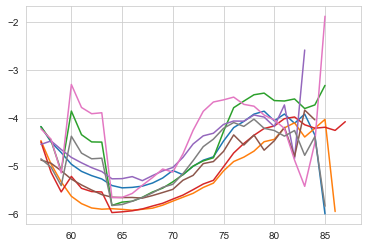

In [17]:
male = [0,1]
states = [0,1,2,3]
ages = [test.par.start_T,test.par.end_T-1]
for ma in male:
    for st in states:
        funs.log_euler(test,male=[ma],states=[st],ages=ages,plot=True)
print('Total:',funs.log_euler(test,ages=ages)[0])

### Can euler errors be improved?

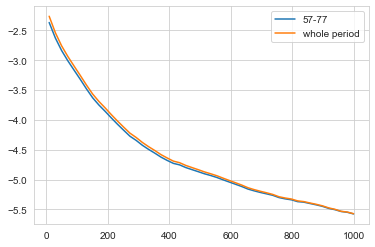

In [57]:
funs.resolve(test,Na=np.linspace(10,1000))
test.par.Na = 200
test.solve(recompute=True) # reset

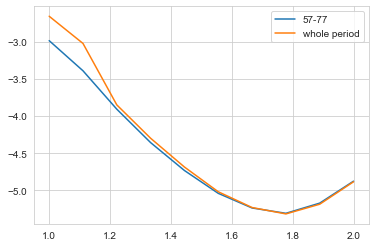

In [7]:
funs.resolve(test,a_phi = np.linspace(1.0,2.0,num=10))
test.par.a_phi = 1.5
test.solve(recompute=True) # reset

# Time the model and simulation

In [3]:
test.par.simT=20

In [4]:
def solve():
    test.solve() 
    
def simulate():
    test.simulate()
    
funcs = [solve,simulate]
argu = dict([(funcs[0], []),
             (funcs[1], [])])
names = dict([(funcs[0], 'solve: #a=' + str(test.par.Na)),
              (funcs[1], 'simulate: T=20, N=' + str(test.par.simN))])

In [5]:
funs.my_timer(funcs,argu,names,unit='s',ndigits=2,Ntimes=100)

time unit is: s
+--------------------------+------+--------+------+------+-------+
|           func           |  lq  | median | mean |  uq  | neval |
+--------------------------+------+--------+------+------+-------+
|      solve: #a=200       | 0.59 |  0.59  | 0.6  | 0.6  | 100.0 |
| simulate: T=20, N=100000 | 1.52 |  1.53  | 1.53 | 1.54 | 100.0 |
+--------------------------+------+--------+------+------+-------+
